In [1]:
import pandas as pd

In [2]:
import gensim
from gensim.models import Word2Vec, KeyedVectors   


In [3]:
from gensim.models import phrases

In [4]:
df=pd.read_csv("full_meta.csv")

In [5]:
df["title"]=df["title"].str.lower()

In [6]:
df=df.set_index("title")

Set full text label for custom additional texts

In [7]:
df["has_ft"]["cohort succession explains most change in literary culture"]=1

C:\Users\lucia\AppData\Local\Temp\ipykernel_10080\3804413159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_ft"]["cohort succession explains most change in literary culture"]=1


In [8]:
df["has_ft"]["the spine of american law"]=1

C:\Users\lucia\AppData\Local\Temp\ipykernel_10080\3072290039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_ft"]["the spine of american law"]=1


In [9]:
df["has_ft"]["redlining_culture"]=1

C:\Users\lucia\AppData\Local\Temp\ipykernel_10080\1283275205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_ft"]["redlining_culture"]=1


In [10]:
df["has_ft"]["distant horizons"]=1

C:\Users\lucia\AppData\Local\Temp\ipykernel_10080\2802389838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_ft"]["distant horizons"]=1


In [11]:
df=df[df["has_ft"]==1]

In [12]:
texts=[]
for t in df["text"]:
    texts.append(t.split(" "))

In [13]:
#generate likely bigrams
bigrams = phrases.Phrases(texts)

In [300]:
#train word2vec with whole corpus
model = Word2Vec(bigrams[texts], vector_size=100, window=25, min_count=5, workers=8)


In [301]:
model.wv.save_word2vec_format('model.bin', binary=True)


In [366]:
#generate custom word embedding of non DH literature
temp=df[(df["literature"]>0.75) & (df["information resources"]<0.3)]
texts=[]
for t in temp["text"]:
    texts.append(t.split(" "))
model = Word2Vec(bigrams[texts], vector_size=100, window=25, min_count=5, workers=6)
model.wv.save_word2vec_format('embed/'+"lit-info"+'.bin', binary=True)


In [312]:
#generate word embeddings for every subject label
for s in list(df.columns)[4:-7]:
    temp=df[df[s]>0.75]
    texts=[]
    for t in temp["text"]:
        texts.append(t.split(" "))
    model = Word2Vec(bigrams[texts], vector_size=100, window=25, min_count=5, workers=6)
    model.wv.save_word2vec_format('embed/'+s+'.bin', binary=True)

    

RuntimeError: you must first build vocabulary before training the model

In [431]:
model=KeyedVectors.load_word2vec_format('model.bin', binary=True, unicode_errors='ignore')


In [44]:
model=KeyedVectors.load_word2vec_format('embed/lit-info.bin', binary=True, unicode_errors='ignore')


In [45]:
keys=["google_ngram","google_books",  "hathitrust", "project_gutenberg", "internet_archive"]
matches=["tool", "methodology", "book", "text", "source", "library", "citation", "data"]

In [46]:
model.similarity(k, m)

0.97925955

In [47]:
spec = pd.DataFrame(0, index=keys, columns=matches)


In [48]:
for k in keys:
    for m in matches:
        try:
            spec[m][k]=model.similarity(k, m)
        except:
            spec[m][k]=0

C:\Users\lucia\AppData\Local\Temp\ipykernel_18908\823247271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spec[m][k]=model.similarity(k, m)


In [49]:
import seaborn as sns

<Axes: >

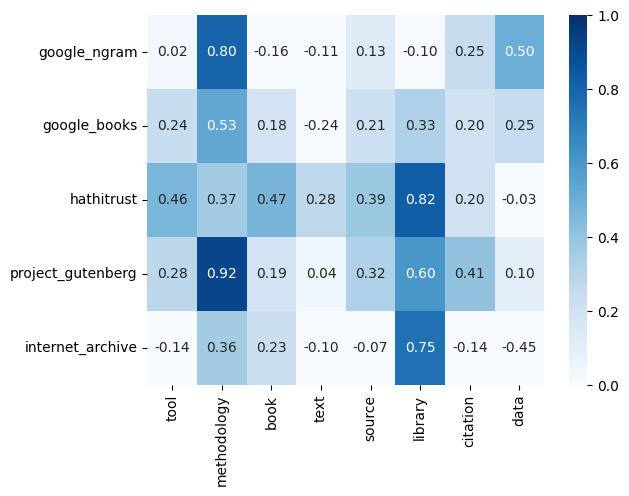

In [15]:
sns.heatmap(spec, cmap="Blues", vmin=0, vmax=1, annot=True,fmt='.2f')

In [14]:
model=KeyedVectors.load_word2vec_format('model.bin', binary=True, unicode_errors='ignore')


In [18]:
keys=["google_ngram","google_books",  "hathitrust", "internet_archive", "gutenberg"]
embedding_clusters = []
word_clusters = []
used_words=[]
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=20):
        used_words.append(similar_word)
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [19]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


In [20]:
from adjustText import adjust_text

C:\Users\lucia\AppData\Local\Temp\ipykernel_10080\3949868120.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


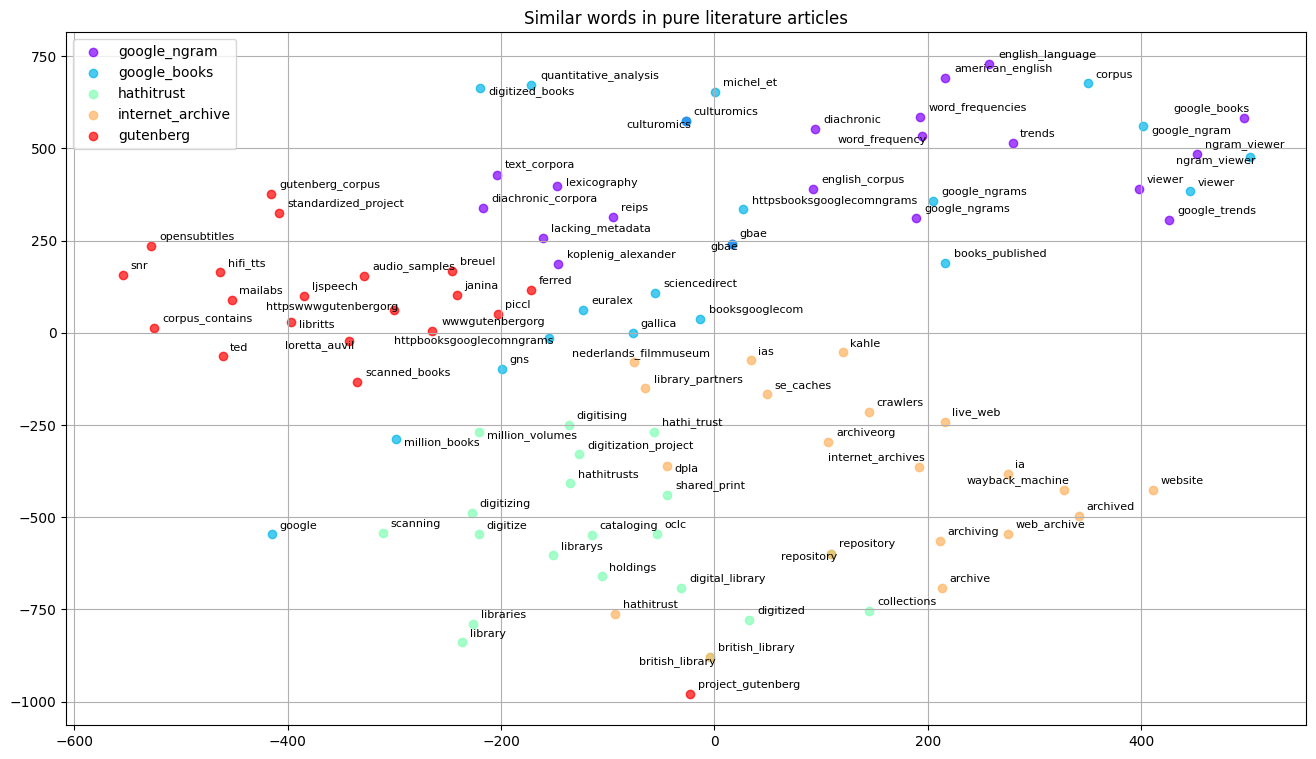

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    texts=[]

    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            texts.append(plt.annotate(word, alpha=1, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8))
    adjust_text(texts)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words in pure literature articles', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')